In [1331]:
import scipy
from scipy.stats import median_abs_deviation as mad
import numpy as np
from matplotlib import pyplot as plt
import time
from  scipy.io import loadmat as loadmat

In [1332]:
rootfolder = '../'

Useful function for the plot

In [1333]:
def display_band( X, par,epsi=0.001,col='k'):
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght 
    k = 0.01
    dx = x2-x1
    dy = y2-y1
    l = np.sqrt(dx**2+dy**2)
    x1 = x1 - k*l
    x2 = x2 + k*l
    y1 = y1 - k*l
    y2 = y2 + k*l
    ##
    if np.abs(par[1])<2e-2 :
        #disp('vertical line')
        a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
        b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
    else:
        a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
        b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

    if np.abs(par[0])<1e-5:
        v = np.array([0,1]) 
    else:    
        v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2))
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v
    a2 = a + epsi * v
    b1 = b - epsi * v
    b2 = b + epsi * v

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
    plt.gca().set_aspect('equal')

def display_clust(X, G, cmap):
    G = np.asarray(G, dtype=int)
    switch_out = 1
    smb = 'o'
    col = []
    num_clust = int(np.max(G))

    for i in range(1, num_clust+1):
        id = G == i
        id = id.squeeze()
        x = X[0, id]
        y = X[1, id]
        if len(col) == 0:
            plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
        else:
            plt.scatter(x,y,50,col,marker=smb,edgecolors=col, alpha=0.1)
        if switch_out == 1:
            id = G == 0
            id = id.squeeze()
            plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)

Function that computes the residual between points and a line

In [1334]:
def res_line(X, M):
  if len(M.shape) > 1:
    num_lines = M.shape[1]
  else:
    num_lines = 1

  if num_lines == 1:
    d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
  else:
    n = X.shape[1]
    d = np.zeros((n, num_lines))
    for i in range(num_lines):
      d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])
  return d


Functions to add outlier to the dataset

In [1335]:
def addOutliersInBB(X, nOutliers, k=0.1):
    xmin = np.min(X[0, :])
    xmax = np.max(X[0, :])
    ymin = np.min(X[1, :])
    ymax = np.max(X[1, :])
    wx = xmax-xmin
    wy = ymax -ymin
    dx = k*wx
    dy = k*wy

    Y = np.hstack((X,np.vstack((xmax-xmin+2*dx * np.random.uniform(size=(1, nOutliers)) + xmin-dx, 
                             ymax-ymin+2*dy * np.random.uniform(size=(1, nOutliers)) + ymin-dy))
                ))
    return Y



Ransac
------
Use the implementation from the last lecture

In [1336]:
def fit_line_dlt(P):
  # design matrix
  ones = np.ones((P.shape[1],1))
  A = np.hstack((P.T,ones))

  # vector of responses 
  y = P.T[:, 1]
  
  # SVD
  U, S, V = np.linalg.svd(A)
  
  # theta
  theta = V.T[:,2]
  
  residuals = A @ theta   
  residual_error = np.sum(residuals ** 2)
  
  return theta, residuals, residual_error

In [1337]:
def simpleRANSAC(X, eps, cardmss = 2):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1] 
  # Desired probability of success
  alpha = 0.99 

  # Pessimistic estimate of inliers fraction
  f = 0.5

  # set maximum number of iterations
  MaxIterations = int(np.log(1-alpha) / np.log(1-(1-f)**cardmss))

  # set maximum consensus reached
  maxscore = -np.inf
 
  for i in range(MaxIterations):
      
    # Generate cardmss random indices in the range 0..n-1
    mss = X[:,np.random.choice(n, cardmss, replace=False)]

    # Fit model to this minimal sample set.
    theta = fit_line_dlt(mss)[0]

    # Evaluate distances between points and model
    sqres = res_line(X, theta)**2

    # identify inliers: consensus set
    inliers = np.where(sqres < eps**2)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta


  return bestmodel, bestinliers

Sequential Ransac
-----------------
Prepare the dataset and set the parameters


In [1338]:
epsi = 0.02 # inlier threshold for ransac

#temp = loadmat(f'{rootfolder}/data/star5.mat')
temp = loadmat(f'{rootfolder}/data/stair4.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers 
G = np.vstack((G, np.zeros((nOut,1))))


C:\Users\chech\AppData\Local\Temp\ipykernel_18572\2832099321.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
C:\Users\chech\AppData\Local\Temp\ipykernel_18572\2832099321.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


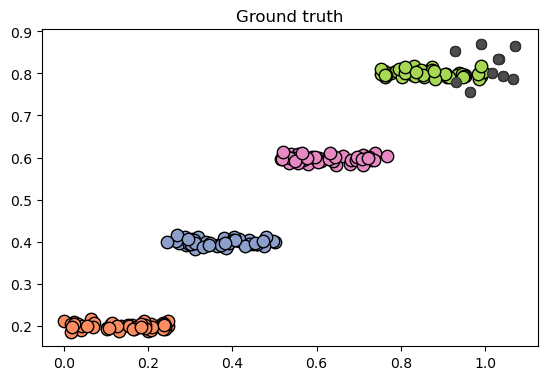

In [1339]:
plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

Implement the sequential ransac algorithm

In [1340]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, inliers = simpleRANSAC(Y, epsi, cardmss)
    currentModel.append(model)
    currentInliers.append(inliers)

    # check if the number of inliers is greater than E_min
    if len(inliers) < E_min:
        break
    
    # remove current inliers
    Y = np.delete(Y, inliers, axis=1)

    # update iterations
    cnt += 1

# TODO: implement another stopping criteria based on the consensus of the last model found


Show the iteration of Sequential Ransac

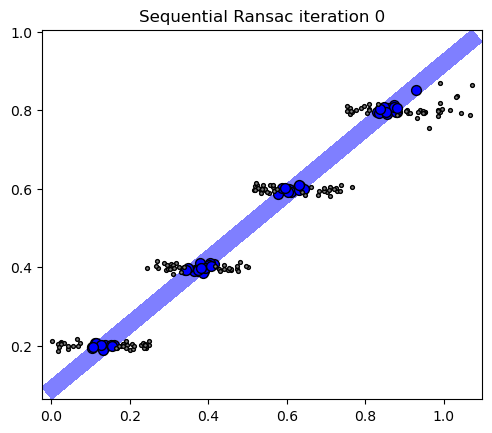

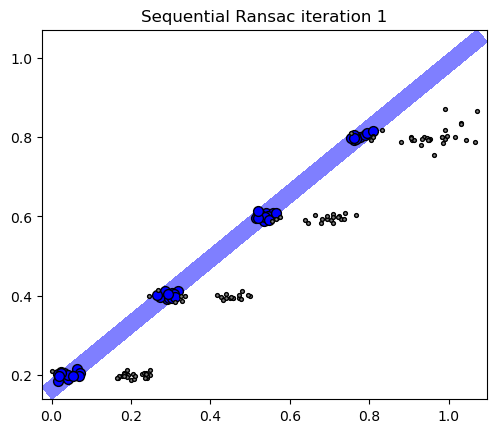

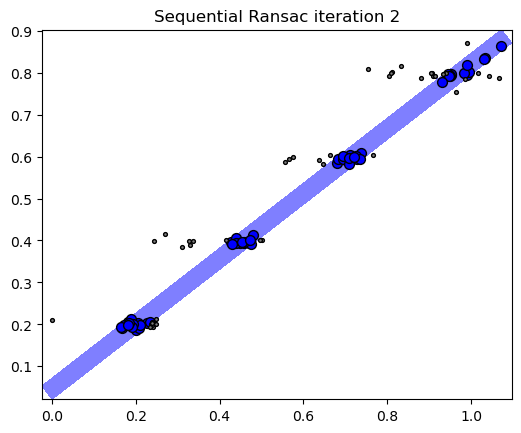

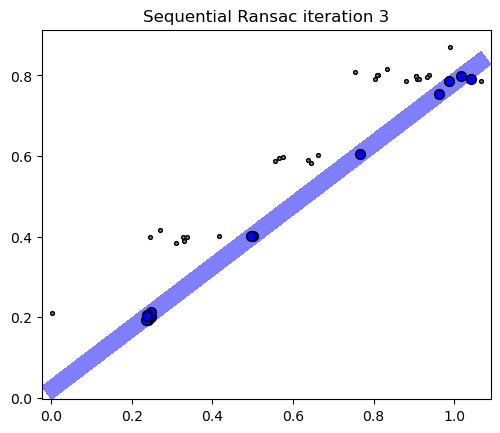

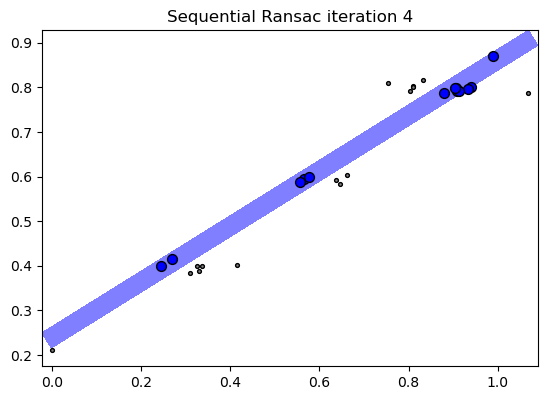

In [1341]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(kappa):
    
    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], epsi, col)

    # plot inliers for this model
    plt.scatter(Y[0,currentInliers[i]], Y[1,currentInliers[i]], 50, col, marker='o', edgecolors='k', alpha=1)
   
    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)    

    # plot the remaining inliers in gray just for guidance
    plt.scatter(Y[0, :], Y[1, :], 30, "gray", marker=".", edgecolors="k")

    plt.title(f'Sequential Ransac iteration {i:d}')
    
    plt.show()

Sequential Ransac Star
-----------------
Prepare the dataset and set the parameters


In [1342]:
epsi = 0.02 # inlier threshold for ransac

temp = loadmat(f'{rootfolder}/data/star5.mat')
# temp = loadmat(f'{rootfolder}/data/stair4.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers 
G = np.vstack((G, np.zeros((nOut,1))))


C:\Users\chech\AppData\Local\Temp\ipykernel_18572\2832099321.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
C:\Users\chech\AppData\Local\Temp\ipykernel_18572\2832099321.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


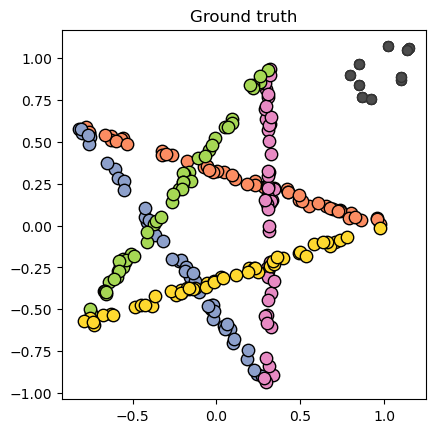

In [1343]:
plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

Implement the sequential ransac algorithm

In [1344]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, inliers = simpleRANSAC(Y, epsi, cardmss)
    currentModel.append(model)
    currentInliers.append(inliers)

    # check if the number of inliers is greater than E_min
    if len(inliers) < E_min:
        break
    
    # remove current inliers
    Y = np.delete(Y, inliers, axis=1)

    # update iterations
    cnt += 1

# TODO: implement another stopping criteria based on the consensus of the last model found


Show the iteration of Sequential Ransac

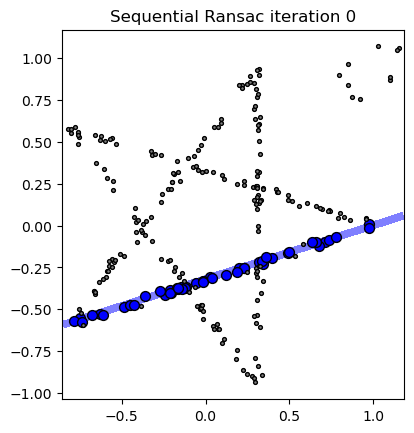

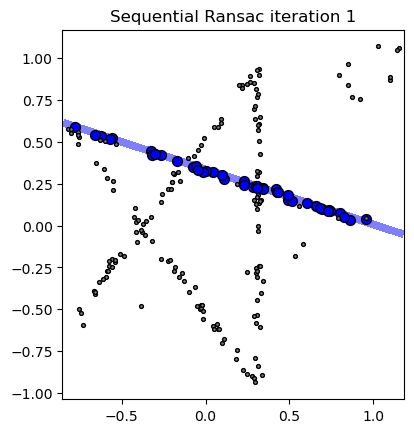

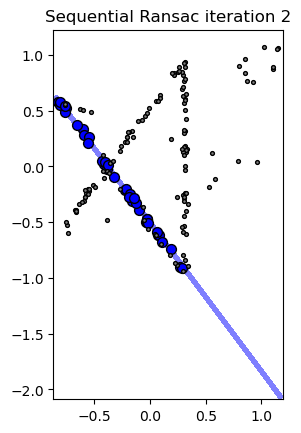

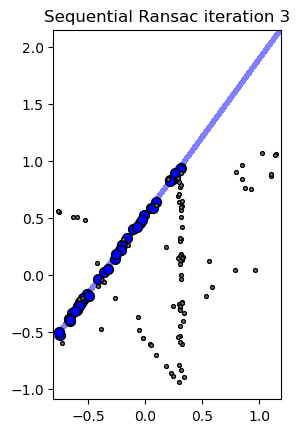

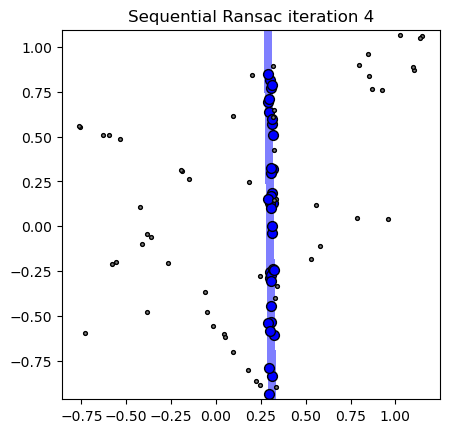

In [1345]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(kappa):
    
    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], epsi, col)

    # plot inliers for this model
    plt.scatter(Y[0,currentInliers[i]], Y[1,currentInliers[i]], 50, col, marker='o', edgecolors='k', alpha=1)
   
    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)    

    # plot the remaining inliers in gray just for guidance
    plt.scatter(Y[0, :], Y[1, :], 30, "gray", marker=".", edgecolors="k")

    plt.title(f'Sequential Ransac iteration {i:d}')
    
    plt.show()

TODO: Try different amount of outliers on both star and stair datasets

TODO: MultiModel fitting on circle
----------------------------
Implement Ransac (thus run Sequential Ransac) to fit circles